<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [2]:
# datos
data = pd.read_csv(r"C:\Users\Lorenzo\Desktop\6.4-lab_ab_testing\data\cookie_cats.csv")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# transformacion
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# Control
g30 = data[data['version'] == 'gate_30']
g30_r1 = g30['retention_1']
g30_r7 = g30['retention_7']
print(sum(g30_r1))
print(sum(g30_r7))
print(len(g30_r1))
print(len(g30_r7))

20034
8502
44700
44700


In [5]:
#Test
g40 = data[data['version'] == 'gate_40']
g40_r1 = g40['retention_1']
g40_r7 = g40['retention_7']
print(sum(g40_r1))
print(sum(g40_r7))
print(len(g40_r1))
print(len(g40_r7))

20119
8279
45489
45489


In [9]:
# muestreo

CR_r1_control = sum(g30_r1)/len(g30_r1)
CR_r1_test = sum(g40_r1)/len(g40_r1)


CR_r7_control = sum(g30_r7)/len(g30_r7)
CR_r7_test = sum(g40_r7)/len(g40_r7)

print('Tasas r1:', 'Tcontrol', CR_r1_control, 'Ttest', CR_r1_test)
print('Tasas r7:','Tcontrol', CR_r7_control, 'Ttest', CR_r7_test)

Tasas r1: Tcontrol 0.4481879194630872 Ttest 0.44228274967574577
Tasas r7: Tcontrol 0.19020134228187918 Ttest 0.18200004396667327


### testeo para retention_1

In [10]:

# se crean funciones beta
# aprioris

from bayes import *

a_C, b_C = sum(g30_r1)+1, len(g30_r1)-sum(g30_r1)+1
a_T, b_T = sum(g40_r1)+1, len(g40_r1)-sum(g40_r1)+1

beta_C=beta(a_C, b_C)  # control
beta_T=beta(a_T, b_T)  # test
print(beta_C)
print(beta_T)

In [11]:
# diferencia normalizada de las medias de test y control

salto=(beta_T.mean()-beta_C.mean())/beta_C.mean()
salto

-0.013175098158249857

In [12]:
prob=calc_prob(beta_C, beta_T)  # esta funcion es la clave
                                # Como el salto es negativo, en la formula pongo beta control antes, nose pk pero funciona(lógica por intuición).
prob

0.9627939748515354

In [13]:
print (
'''El test aumenta la tasa de retorno en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto*100, prob*100)
)

El test aumenta la tasa de conversion en un -1.32%,
con una probabilidad del 96.28%


0.4481879194630872 0.44228274967574577


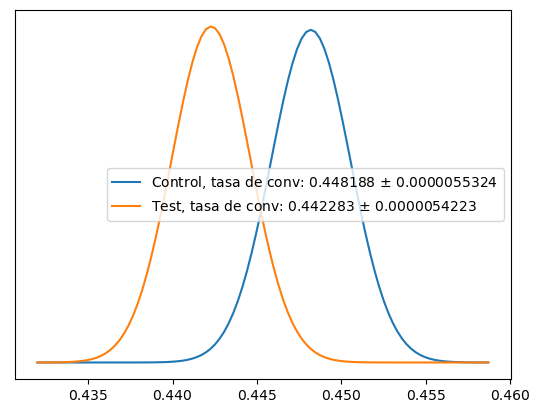

In [24]:
print (CR_r1_control , CR_r1_test)
plot([beta_C, beta_T], ['Control', 'Test'], linf=0.432, lsup=0.4587)

### testeo para retention_7


In [110]:
CR_r1_control = sum(g30_r1)/len(g30_r1)
CR_r1_test = sum(g40_r1)/len(g40_r1)


CR_r7_control = sum(g30_r7)/len(g30_r7)
CR_r7_test = sum(g40_r7)/len(g40_r7)

print('Tasas r1:', 'Tcontrol', CR_r1_control, 'Ttest', CR_r1_test)
print('Tasas r7:','Tcontrol', CR_r7_control, 'Ttest', CR_r7_test)

Tasas r1: Tcontrol 0.4481879194630872 Ttest 0.44228274967574577
Tasas r7: Tcontrol 0.19020134228187918 Ttest 0.18200004396667327


In [111]:
# se crean funciones beta
# aprioris

a_C, b_C = sum(g30_r7)+1, len(g30_r7)-sum(g30_r7)+1
a_T, b_T = sum(g40_r7)+1, len(g40_r7)-sum(g40_r7)+1

beta_C=beta(a_C, b_C)  # control
beta_T=beta(a_T, b_T)  # test


In [113]:
salto=(beta_T.mean()-beta_C.mean())/beta_C.mean()
salto

-0.04311526114658881

In [115]:
prob=calc_prob(beta_C, beta_T)  # esta funcion es la clave

prob

0.9992226613235504

In [116]:

print (
'''El test aumenta la tasa de retorno en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto*100, prob*100)
)

El test aumenta la tasa de conversion en un -4.31%,
con una probabilidad del 99.92%


0.19020134228187918 0.18200004396667327


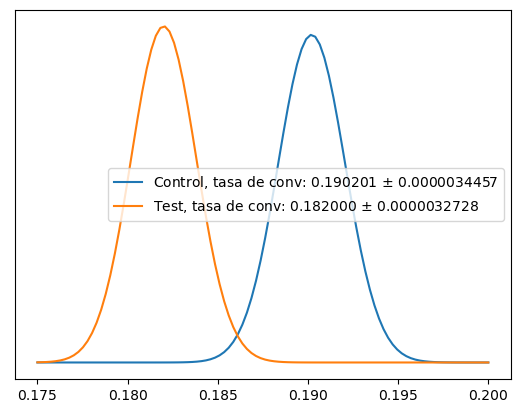

In [123]:
print (CR_r7_control, CR_r7_test)
plot([beta_C, beta_T], ['Control', 'Test'],linf=0.175,  lsup=0.2)

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

## CONCLUSIONES:

### R1:
#### El test aumenta la tasa de retorno en un -1.32%, con una probabilidad del 96.28%
#### Podemos concluir que al 96,28% de probabilidad la nueva actualizacion de desbloqueo de niveles va a bajar, la tasa de retorno al juego en el primer dia, en un 1.32% de media.
### R2:
#### El test aumenta la tasa de retorno en un -4.31%, con una probabilidad del 99.92%
#### Podemos concluir que al 99,92% de probabilidad la nueva actualizacion de desbloqueo de niveles va a bajar, la tasa de retorno al juego en el séptimo dia, en un 4,31% de media.